In [1]:

%matplotlib inline 
import json
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D 

In [2]:
def convert_unity_to_standard_system(position):
    pos = np.array([position[0], position[1], -position[2]])
    # Define the rotation matrix
    R = np.array([[1, 0, 0],
                  [0, 0, -1],
                  [0, 1, 0]])
    return np.dot(R, pos)

In [3]:
raw_data = json.load(open('awsim_data/new_car_data.json'))

In [4]:
raw_data[412]

{'SimTsUs': 638619048116290786,
 'RenderTsUs': 0,
 'Vel': {'x': -4.1336350440979,
  'y': -0.0017750861588865519,
  'z': 3.905895233154297},
 'Acc': {'x': 0.0, 'y': 0.0, 'z': 0.0},
 'Rot': {'x': 359.9423828125, 'y': 319.030029296875, 'z': 358.8927001953125},
 'Pos': {'x': -3.9997246265411377,
  'y': 0.022385239601135254,
  'z': -35.45488739013672},
 'Forward': {'x': -0.6556629538536072,
  'y': 0.0010058633051812649,
  'z': 0.7550531029701233},
 'Step': 675,
 'AngularVel': {'x': -0.017076440155506134,
  'y': -0.5294092893600464,
  'z': 0.013899245299398899},
 'WheeledVehicleData': {'Wheels': [{'_4wdInd': 1,
    'AngVel': 0.0003819716803263873,
    'ReqTorq': 9.999999747378752e-06,
    'ReqBreakTorq': 0.0,
    'Steer': -15.0,
    'Sus': 378.91436767578125,
    'LongSlip': -0.9815890789031982,
    'LatSlip': -0.0016079171327874064},
   {'_4wdInd': 2,
    'AngVel': 0.0003819716803263873,
    'ReqTorq': 9.999999747378752e-06,
    'ReqBreakTorq': 0.0,
    'Steer': -15.0,
    'Sus': 392.048828

In [41]:
def data_item_to_single_dict(item):
    final_dict = {}
    final_dict['step'] = item['Step']
    final_dict['micro_time'] = item['SimTsUs']
    final_dict['time'] = item['SimTsUs']/1e6
    final_dict['velocity'] = convert_unity_to_standard_system(np.array([item['Vel']['x'], item['Vel']['y'], item['Vel']['z']]))
    final_dict['position'] = convert_unity_to_standard_system(np.array([item['Pos']['x'], item['Pos']['y'], item['Pos']['z']]))
    final_dict['position_x'] = item['Pos']['x']
    final_dict['position_y'] = item['Pos']['y']
    final_dict['position_z'] = -item['Pos']['z']
    final_dict['forward'] = convert_unity_to_standard_system(np.array([item['Forward']['x'], item['Forward']['y'], item['Forward']['z']]))
    final_dict['rotation'] = np.deg2rad(convert_unity_to_standard_system(np.array([item['Rot']['x'], item['Rot']['y'], item['Rot']['z']])))
    final_dict['acceleration'] = convert_unity_to_standard_system(np.array([item['Acc']['x'], item['Acc']['y'], item['Acc']['z']]))
    final_dict['angular_velocity'] = np.deg2rad(convert_unity_to_standard_system(np.array([item['AngularVel']['x'], item['AngularVel']['y'], item['AngularVel']['z']])))
    final_dict['friction'] = item['friction']
    return final_dict

In [42]:
data = []
for item in raw_data[100:]:
    try:
        data.append(data_item_to_single_dict(item))
    except KeyError:
        print(item)

{}


In [49]:
# For each item in the data, we will rotate the velocity and acceleration vectors to the local reference frame
# We also calculate the time difference between each item, and the vehicle's acceleration.
from scipy.spatial.transform import Rotation as R
for idx, item in enumerate(data):
    # Estimate the yaw from the position difference between the current and next item
    if idx < len(data) - 1:
        data[idx]['dt'] = data[idx+1]['time'] - data[idx]['time']
    ANGLE_OFFSET = -np.pi/2
    yaw = (np.arctan2(item['forward'][1], item['forward'][0]) + ANGLE_OFFSET + np.pi) # % (2*np.pi) - np.pi
    data[idx]['calc_rotation'] = np.array([0., 0., item['rotation'][2] + ANGLE_OFFSET])
    # data[idx]['rotation'][2] = data[idx]['rotation'][2] + np.pi/2
    rot_mat = R.from_euler('z', yaw).as_matrix()
    local_velocity = rot_mat @ item['velocity']
    local_acceleration = rot_mat @ item['acceleration']
        
for idx in range(len(data) - 1):
    data[idx]['calculated_acceleration'] = (data[idx+1]['local_velocity'] - data[idx]['local_velocity']) / data[idx]['dt']
    # Calculate the slip angle based on the local velocity
    data[idx]['slip_angle'] = np.arctan2(data[idx]['local_velocity'][1], data[idx]['local_velocity'][0])

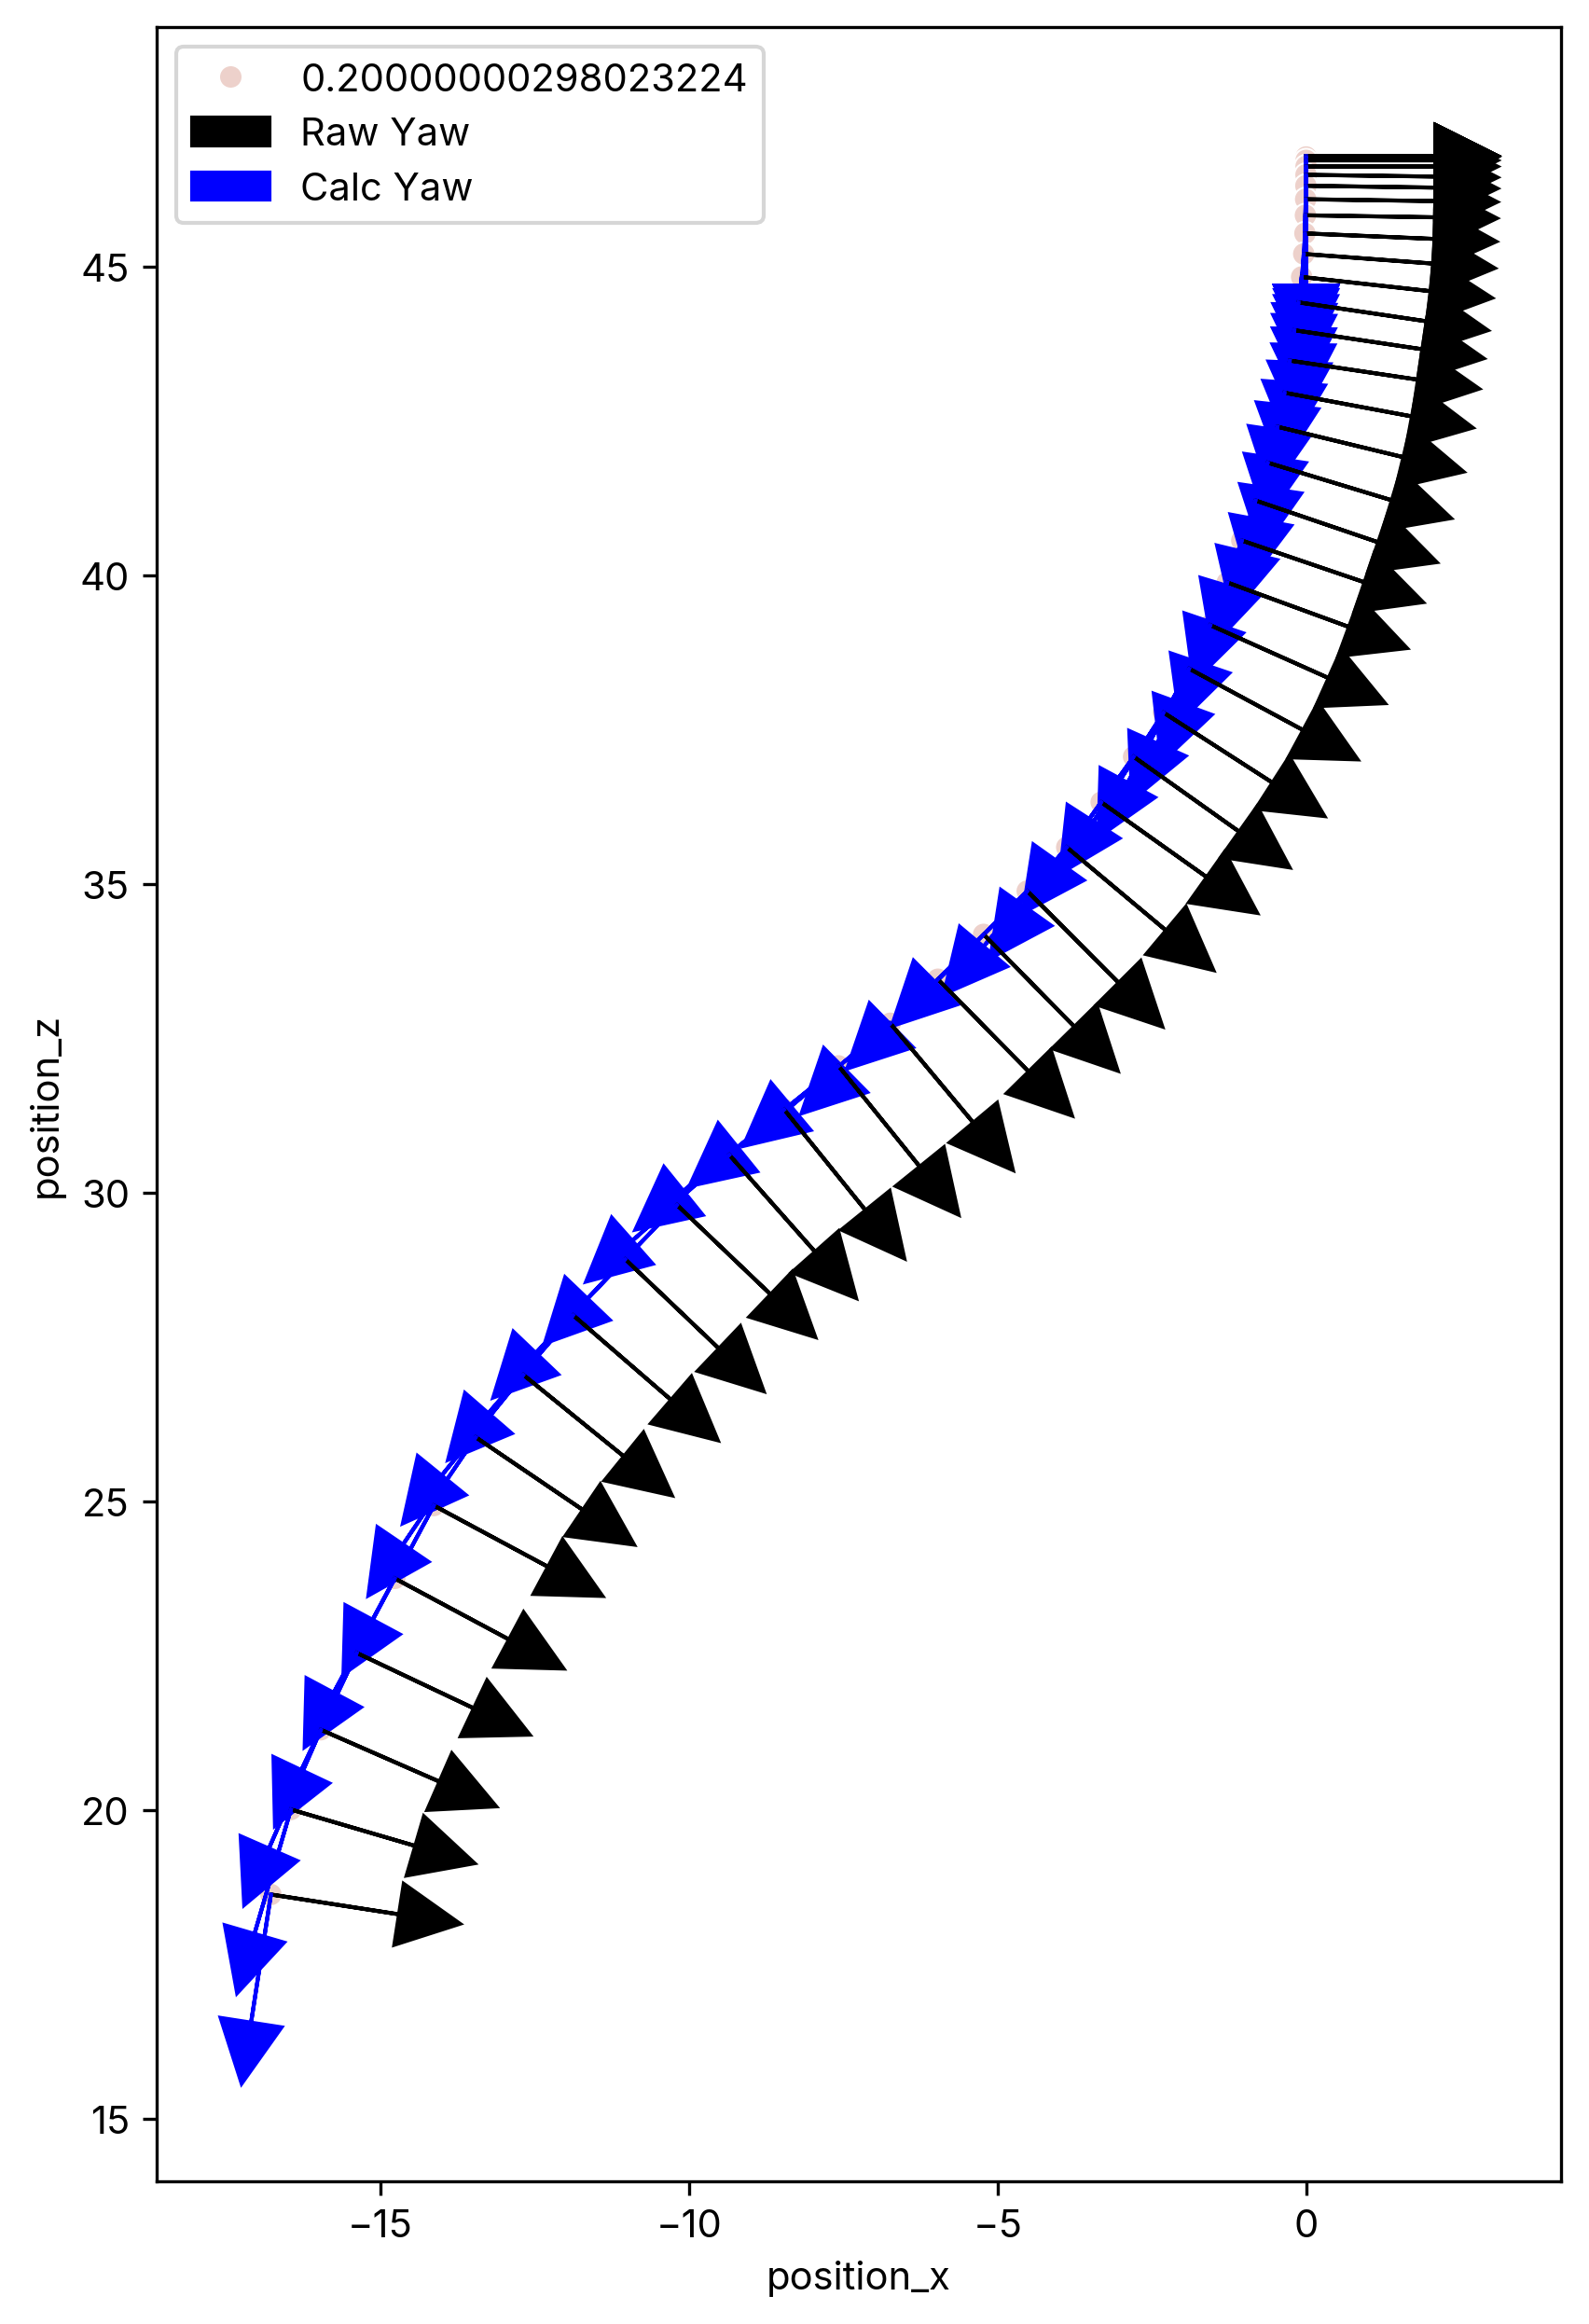

In [50]:
# Plot the position of the car in x and z, with the color as the friction value, using seaborn
import seaborn as sns
import pandas as pd

START, FINISH, STEP = 0, len(data)//5, 10
df = pd.DataFrame(data[START:FINISH:STEP])
df.sort_values('time', inplace=True)
# Plot the position of the car in x and z, with the color as the friction value, using seaborn
fig, ax = plt.subplots(figsize=(10, 10,))
sns.scatterplot(data=df, x='position_x', y='position_z', hue='friction', markers='.')
# Plot the yaw of the car on the plot
for idx in range(0, len(data)//5, 10):
    ANGLE_OFFSET = 0
    ax.arrow(data[idx]['position_x'], data[idx]['position_z'], 2.1*np.cos(data[idx]['rotation'][2]+ANGLE_OFFSET), 2.1*np.sin(data[idx]['rotation'][2]+ANGLE_OFFSET), head_width=1.0, head_length=1.0, fc='k', ec='k', label='Raw Yaw')
    # Plot calculated rotation
    ax.arrow(data[idx]['position_x'], data[idx]['position_z'], 2.1*np.cos(data[idx]['calc_rotation'][2]+ANGLE_OFFSET), 2.1*np.sin(data[idx]['calc_rotation'][2]+ANGLE_OFFSET), head_width=1.0, head_length=1.0, fc='b', ec='b', label='Calc Yaw')
    # Plot the velocity vector
    # ax.arrow(data[idx]['position_x'], data[idx]['position_z'], data[idx]['local_velocity'][0], data[idx]['local_velocity'][1], head_width=1.0, head_length=1.0, fc='r', ec='r')    
    if idx == 0:
        ax.legend()
ax.set_aspect('equal')

In [51]:
data = data[:-1]
data_columns = {
    'step': np.array([item['step'] for item in data]),
    'micro_time': np.array([item['micro_time'] for item in data]),
    'time': np.array([item['time'] for item in data]),
    'dt': np.array([item['dt'] for item in data]),
    'velocity': np.array([item['velocity'] for item in data]),
    'position': np.array([item['position'] for item in data]),
    'acceleration': np.array([item['acceleration'] for item in data]),
    'local_velocity': np.array([item['local_velocity'] for item in data]),
    'local_acceleration': np.array([item['local_acceleration'] for item in data]),
    'calculated_acceleration': np.array([item['calculated_acceleration'] for item in data]),
    'forward': np.array([item['forward'] for item in data]),
    # 'position_x': np.array([item['position_x'] for item in data]),
    # 'position_y': np.array([item['position_y'] for item in data]),
    # 'position_z': np.array([item['position_z'] for item in data]),
    'rotation': np.array([item['rotation'] for item in data]),
    'calc_rotation': np.array([item['calc_rotation'] for item in data]),
    'angular_velocity': np.array([item['angular_velocity'] for item in data]),
    'slip_angle': np.array([item['slip_angle'] for item in data]),
    'friction': np.array([item['friction'] for item in data]),
}

In [52]:
# # Plot the position of the car in three separate plots, each stacked in the same figure
# plt.figure(figsize=(5, 8), constrained_layout=True)
# plt.subplot(4, 1, 1)
# plt.plot(data_columns['time'], data_columns['position_x'])
# plt.title('Position X')
# plt.xlabel('Time (s)')
# plt.ylabel('Position (m)')
# plt.grid()
# plt.subplot(4, 1, 2)
# plt.plot(data_columns['time'], data_columns['position_y'])
# plt.title('Position Y')
# plt.xlabel('Time (s)')
# plt.ylabel('Position (m)')
# plt.grid()
# plt.subplot(4, 1, 3)
# plt.plot(data_columns['time'], data_columns['position_z'])
# plt.title('Position Z')
# plt.xlabel('Time (s)')
# plt.ylabel('Position (m)')
# plt.grid()
# plt.subplot(4, 1, 4)
# plt.plot(data_columns['time'], data_columns['friction'])
# plt.title('Friction')
# plt.xlabel('Time (s)')
# plt.ylabel('Friction')
# plt.grid()

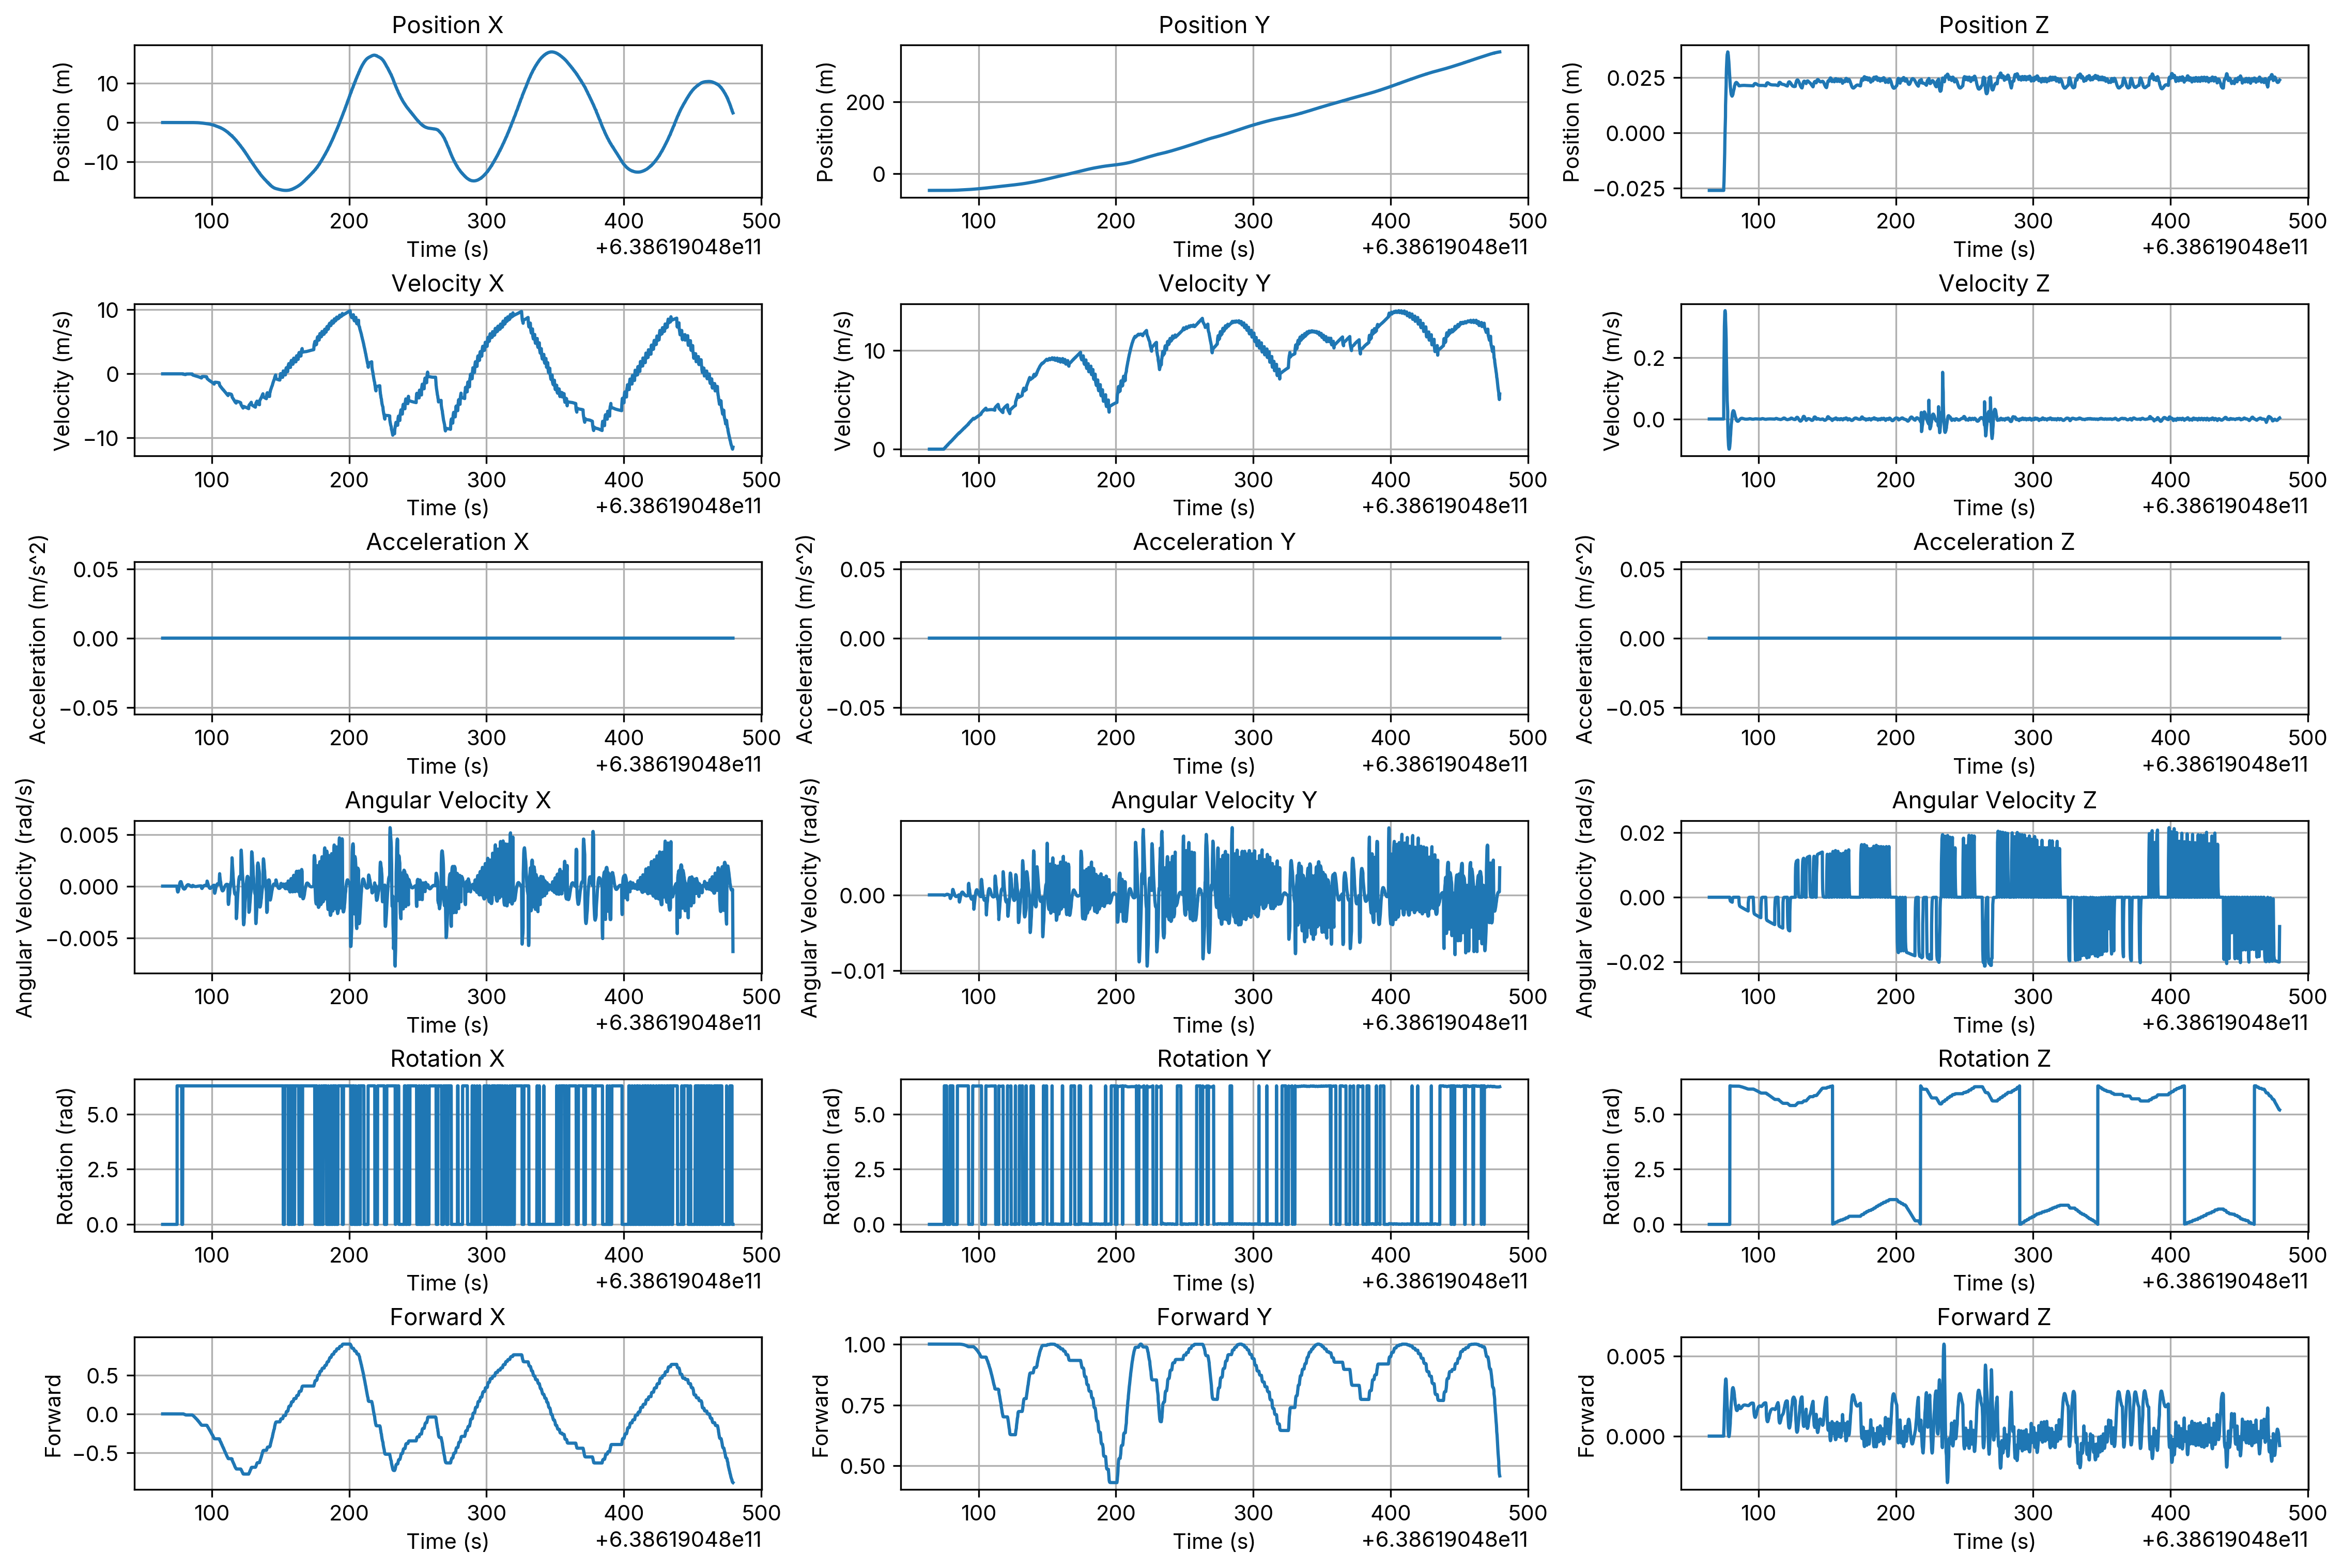

In [53]:
# Plot all of the states of the car in a series of subplots
fig, axs = plt.subplots(6, 3, figsize=(15, 10), constrained_layout=True)

# Plot x y and z position separately
axs[0, 0].plot(data_columns['time'], data_columns['position'][:, 0])
axs[0, 0].set_title('Position X')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Position (m)')
axs[0, 0].grid()
axs[0, 1].plot(data_columns['time'], data_columns['position'][:, 1])
axs[0, 1].set_title('Position Y')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Position (m)')
axs[0, 1].grid()
axs[0, 2].plot(data_columns['time'], data_columns['position'][:, 2])
axs[0, 2].set_title('Position Z')
axs[0, 2].set_xlabel('Time (s)')
axs[0, 2].set_ylabel('Position (m)')
axs[0, 2].grid()

# Plot the velocity in x y and z
axs[1, 0].plot(data_columns['time'], data_columns['velocity'][:, 0])
axs[1, 0].set_title('Velocity X')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Velocity (m/s)')
axs[1, 0].grid()
axs[1, 1].plot(data_columns['time'], data_columns['velocity'][:, 1])
axs[1, 1].set_title('Velocity Y')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Velocity (m/s)')
axs[1, 1].grid()
axs[1, 2].plot(data_columns['time'], data_columns['velocity'][:, 2])
axs[1, 2].set_title('Velocity Z')
axs[1, 2].set_xlabel('Time (s)')
axs[1, 2].set_ylabel('Velocity (m/s)')
axs[1, 2].grid()

# Plot the acceleration in x y and z
axs[2, 0].plot(data_columns['time'], data_columns['acceleration'][:, 0])
axs[2, 0].set_title('Acceleration X')
axs[2, 0].set_xlabel('Time (s)')
axs[2, 0].set_ylabel('Acceleration (m/s^2)')
axs[2, 0].grid()
axs[2, 1].plot(data_columns['time'], data_columns['acceleration'][:, 1])
axs[2, 1].set_title('Acceleration Y')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Acceleration (m/s^2)')
axs[2, 1].grid()
axs[2, 2].plot(data_columns['time'], data_columns['acceleration'][:, 2])
axs[2, 2].set_title('Acceleration Z')
axs[2, 2].set_xlabel('Time (s)')
axs[2, 2].set_ylabel('Acceleration (m/s^2)')
axs[2, 2].grid()

# Plot the angular velocity in x y and z
axs[3, 0].plot(data_columns['time'], data_columns['angular_velocity'][:, 0])
axs[3, 0].set_title('Angular Velocity X')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Angular Velocity (rad/s)')
axs[3, 0].grid()
axs[3, 1].plot(data_columns['time'], data_columns['angular_velocity'][:, 1])
axs[3, 1].set_title('Angular Velocity Y')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('Angular Velocity (rad/s)')
axs[3, 1].grid()
axs[3, 2].plot(data_columns['time'], data_columns['angular_velocity'][:, 2])
axs[3, 2].set_title('Angular Velocity Z')
axs[3, 2].set_xlabel('Time (s)')
axs[3, 2].set_ylabel('Angular Velocity (rad/s)')
axs[3, 2].grid()

# Plot the rotation in x y and z
axs[4, 0].plot(data_columns['time'], data_columns['rotation'][:, 0])
axs[4, 0].set_title('Rotation X')
axs[4, 0].set_xlabel('Time (s)')
axs[4, 0].set_ylabel('Rotation (rad)')
axs[4, 0].grid()
axs[4, 1].plot(data_columns['time'], data_columns['rotation'][:, 1])
axs[4, 1].set_title('Rotation Y')
axs[4, 1].set_xlabel('Time (s)')
axs[4, 1].set_ylabel('Rotation (rad)')
axs[4, 1].grid()
axs[4, 2].plot(data_columns['time'], data_columns['rotation'][:, 2])
axs[4, 2].set_title('Rotation Z')
axs[4, 2].set_xlabel('Time (s)')
axs[4, 2].set_ylabel('Rotation (rad)')
axs[4, 2].grid()

# Plot the forward vector in x y and z 
axs[5, 0].plot(data_columns['time'], data_columns['forward'][:, 0])
axs[5, 0].set_title('Forward X')
axs[5, 0].set_xlabel('Time (s)')
axs[5, 0].set_ylabel('Forward')
axs[5, 0].grid()
axs[5, 1].plot(data_columns['time'], data_columns['forward'][:, 1])
axs[5, 1].set_title('Forward Y')
axs[5, 1].set_xlabel('Time (s)')
axs[5, 1].set_ylabel('Forward')
axs[5, 1].grid()
axs[5, 2].plot(data_columns['time'], data_columns['forward'][:, 2])
axs[5, 2].set_title('Forward Z')
axs[5, 2].set_xlabel('Time (s)')
axs[5, 2].set_ylabel('Forward')
axs[5, 2].grid()


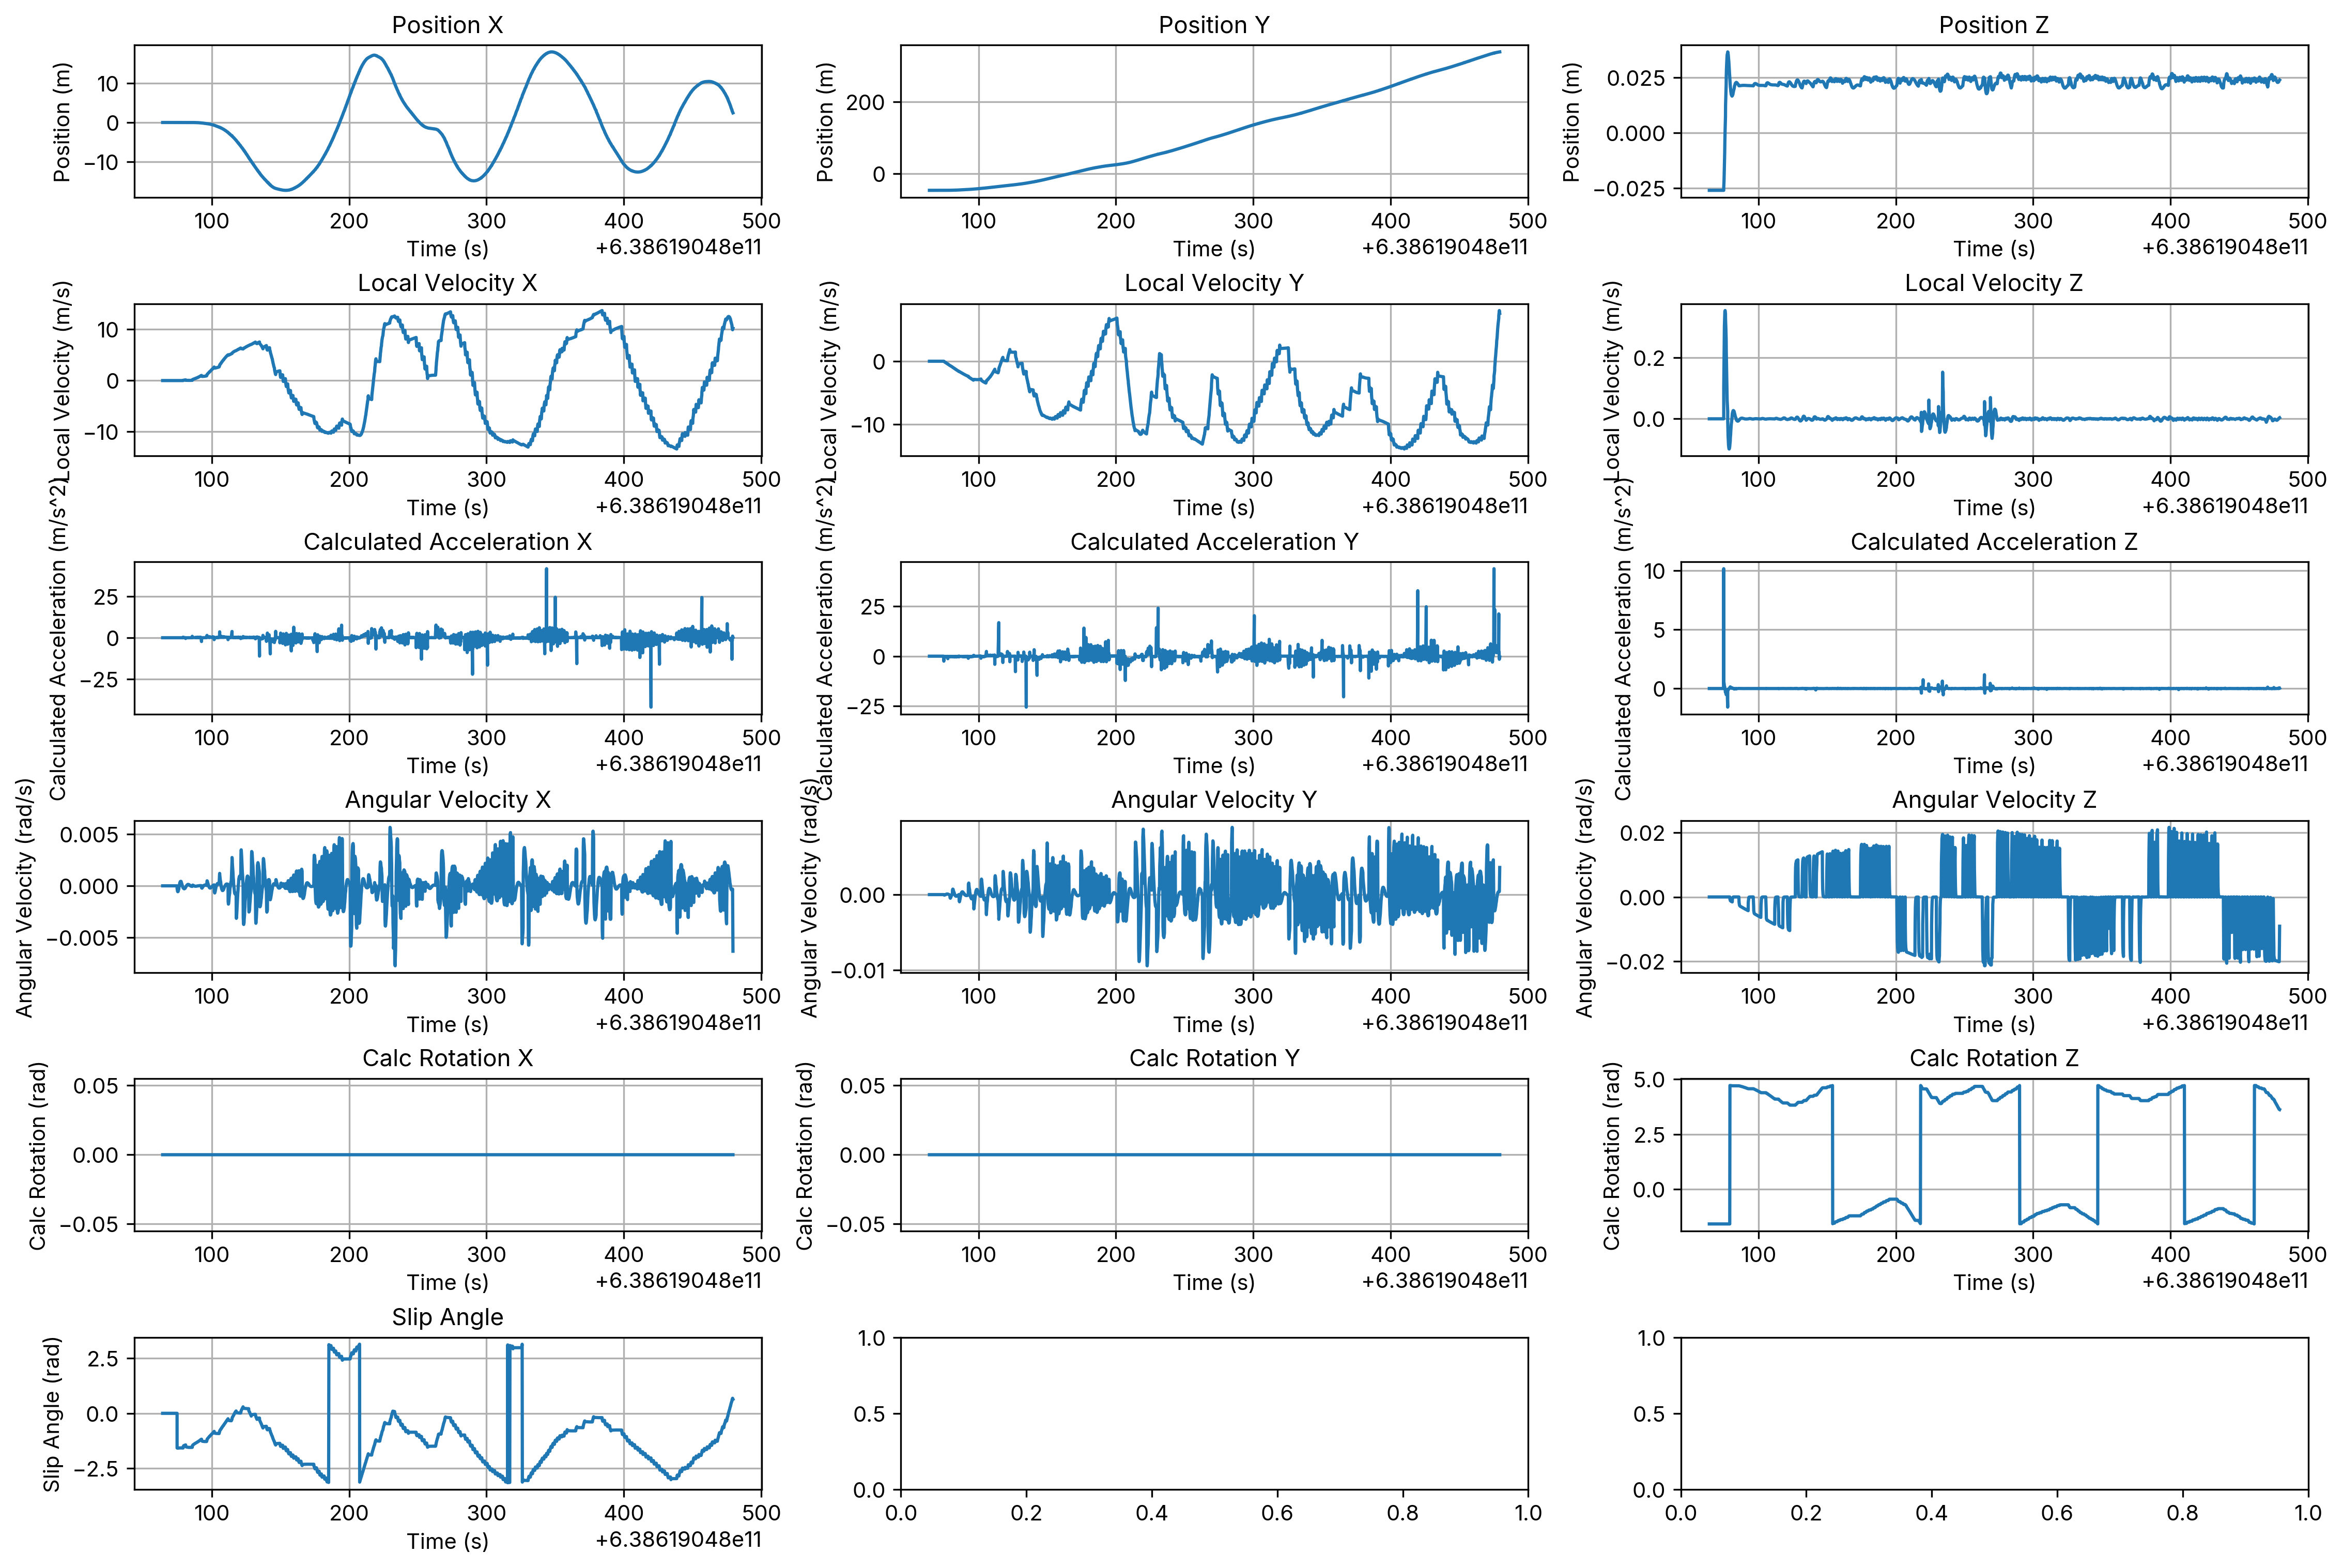

In [54]:
# Plot all of the states of the car in a series of subplots
fig, axs = plt.subplots(6, 3, figsize=(15, 10), constrained_layout=True)

# Plot x y and z position separately
axs[0, 0].plot(data_columns['time'], data_columns['position'][:, 0])
axs[0, 0].set_title('Position X')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Position (m)')
axs[0, 0].grid()
axs[0, 1].plot(data_columns['time'], data_columns['position'][:, 1])
axs[0, 1].set_title('Position Y')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Position (m)')
axs[0, 1].grid()
axs[0, 2].plot(data_columns['time'], data_columns['position'][:, 2])
axs[0, 2].set_title('Position Z')
axs[0, 2].set_xlabel('Time (s)')
axs[0, 2].set_ylabel('Position (m)')
axs[0, 2].grid()

# Plot the local velocity in x y and z
axs[1, 0].plot(data_columns['time'], data_columns['local_velocity'][:, 0])
axs[1, 0].set_title('Local Velocity X')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Local Velocity (m/s)')
axs[1, 0].grid()
axs[1, 1].plot(data_columns['time'], data_columns['local_velocity'][:, 1])
axs[1, 1].set_title('Local Velocity Y')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Local Velocity (m/s)')
axs[1, 1].grid()
axs[1, 2].plot(data_columns['time'], data_columns['local_velocity'][:, 2])
axs[1, 2].set_title('Local Velocity Z')
axs[1, 2].set_xlabel('Time (s)')
axs[1, 2].set_ylabel('Local Velocity (m/s)')
axs[1, 2].grid()

# Plot the local acceleration in x y and z
axs[2, 0].plot(data_columns['time'], data_columns['calculated_acceleration'][:, 0])
axs[2, 0].set_title('Calculated Acceleration X')
axs[2, 0].set_xlabel('Time (s)')
axs[2, 0].set_ylabel('Calculated Acceleration (m/s^2)')
axs[2, 0].grid()
axs[2, 1].plot(data_columns['time'], data_columns['calculated_acceleration'][:, 1])
axs[2, 1].set_title('Calculated Acceleration Y')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Calculated Acceleration (m/s^2)')
axs[2, 1].grid()
axs[2, 2].plot(data_columns['time'], data_columns['calculated_acceleration'][:, 2])
axs[2, 2].set_title('Calculated Acceleration Z')
axs[2, 2].set_xlabel('Time (s)')
axs[2, 2].set_ylabel('Calculated Acceleration (m/s^2)')
axs[2, 2].grid()

# Plot the angular velocity in x y and z
axs[3, 0].plot(data_columns['time'], data_columns['angular_velocity'][:, 0])
axs[3, 0].set_title('Angular Velocity X')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Angular Velocity (rad/s)')
axs[3, 0].grid()
axs[3, 1].plot(data_columns['time'], data_columns['angular_velocity'][:, 1])
axs[3, 1].set_title('Angular Velocity Y')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('Angular Velocity (rad/s)')
axs[3, 1].grid()
axs[3, 2].plot(data_columns['time'], data_columns['angular_velocity'][:, 2])
axs[3, 2].set_title('Angular Velocity Z')
axs[3, 2].set_xlabel('Time (s)')
axs[3, 2].set_ylabel('Angular Velocity (rad/s)')
axs[3, 2].grid()

# Plot the rotation in x y and z
axs[4, 0].plot(data_columns['time'], data_columns['calc_rotation'][:, 0])
axs[4, 0].set_title('Calc Rotation X')
axs[4, 0].set_xlabel('Time (s)')
axs[4, 0].set_ylabel('Calc Rotation (rad)')
axs[4, 0].grid()
axs[4, 1].plot(data_columns['time'], data_columns['calc_rotation'][:, 1])
axs[4, 1].set_title('Calc Rotation Y')
axs[4, 1].set_xlabel('Time (s)')
axs[4, 1].set_ylabel('Calc Rotation (rad)')
axs[4, 1].grid()
axs[4, 2].plot(data_columns['time'], data_columns['calc_rotation'][:, 2])
axs[4, 2].set_title('Calc Rotation Z')
axs[4, 2].set_xlabel('Time (s)')
axs[4, 2].set_ylabel('Calc Rotation (rad)')
axs[4, 2].grid()

# Plot the slip angle
axs[5, 0].plot(data_columns['time'], data_columns['slip_angle'])
axs[5, 0].set_title('Slip Angle')
axs[5, 0].set_xlabel('Time (s)')
axs[5, 0].set_ylabel('Slip Angle (rad)')
axs[5, 0].grid()


In [55]:
# Let's integrate the velocity to get the position
position = np.zeros_like(data_columns['position'])
position[0] = data_columns['position'][0]
for i in range(1, len(data_columns['position'])):
    position[i] = position[i-1] + data_columns['velocity'][i] * (data_columns['time'][i] - data_columns['time'][i-1])

In [56]:
# Let's take the derivative of the position to get the velocity
velocity = data_columns['position'][1:] - data_columns['position'][:-1]
# Now we integrate this back to get the position
dp_position = np.zeros_like(data_columns['position'])
dp_position[0] = data_columns['position'][0]
for i in range(1, len(data_columns['position'])):
    dp_position[i] = dp_position[i-1] + velocity[i-1] * (data_columns['time'][i] - data_columns['time'][i-1])
    

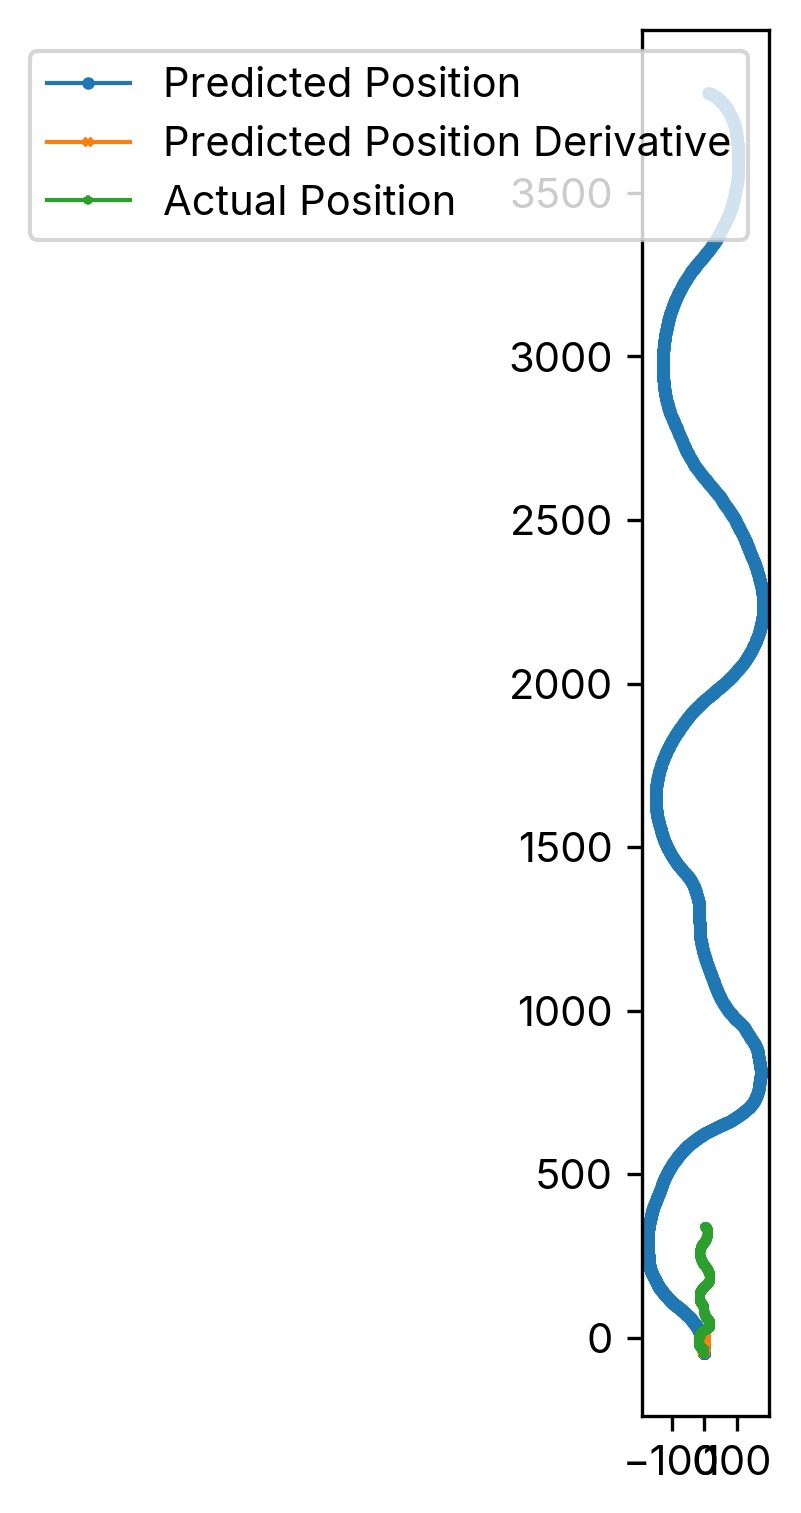

In [57]:
# Plot the predicted position and the actual position
plt.figure(figsize=(6, 6))
plt.plot(position[:, 0], position[:, 1], marker='o', linewidth=1, markersize=2, label='Predicted Position')
plt.plot(dp_position[:, 0], dp_position[:, 1], marker='x', linewidth=1, markersize=2, label='Predicted Position Derivative')
plt.plot(data_columns['position'][:, 0], data_columns['position'][:, 1], marker='*', linewidth=1, markersize=2, label='Actual Position')
plt.legend()
# Set the aspect ratio of the plot to be equal
plt.gca().set_aspect('equal', adjustable='box')

Text(0, 0.5, 'Time Step')

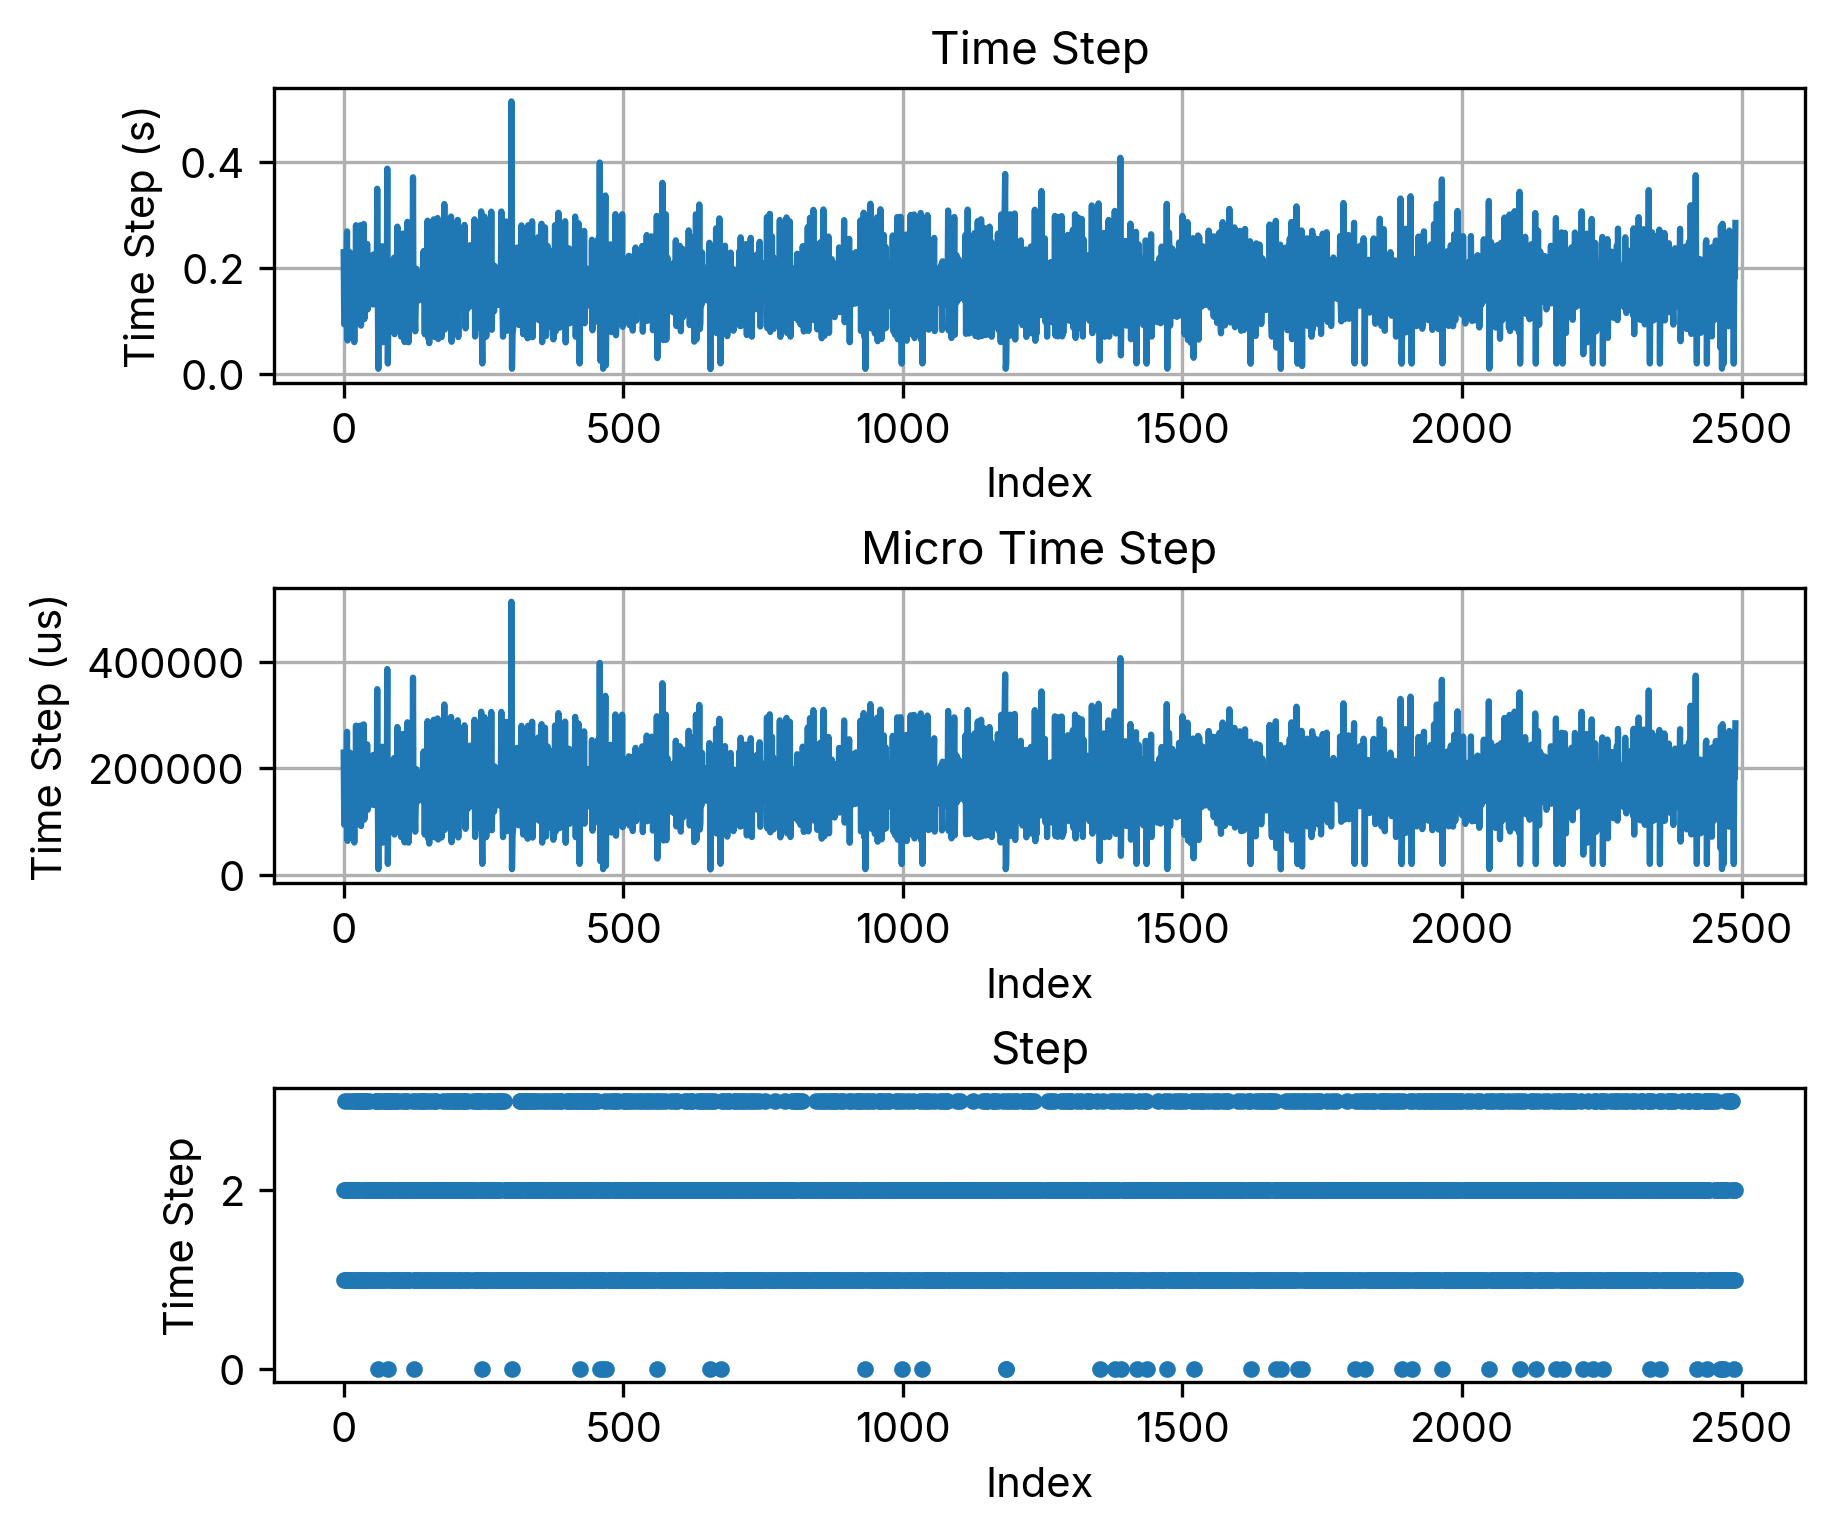

In [58]:
# Aggregate the three plots above into a single figure
fig, axs = plt.subplots(3, 1, figsize=(6, 5), constrained_layout=True)
axs[0].plot(data_columns['time'][1:]- data_columns['time'][:-1], label='Time Step')
axs[0].set_title('Time Step')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Time Step (s)')
axs[0].grid()
axs[1].plot(data_columns['micro_time'][1:]- data_columns['micro_time'][:-1], label='Time Step')
axs[1].set_title('Micro Time Step')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Time Step (us)')
axs[1].grid()
axs[2].plot(data_columns['step'][1:]- data_columns['step'][:-1], label='Time Step', marker='.', linestyle='None')
axs[2].set_title('Step')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Time Step')


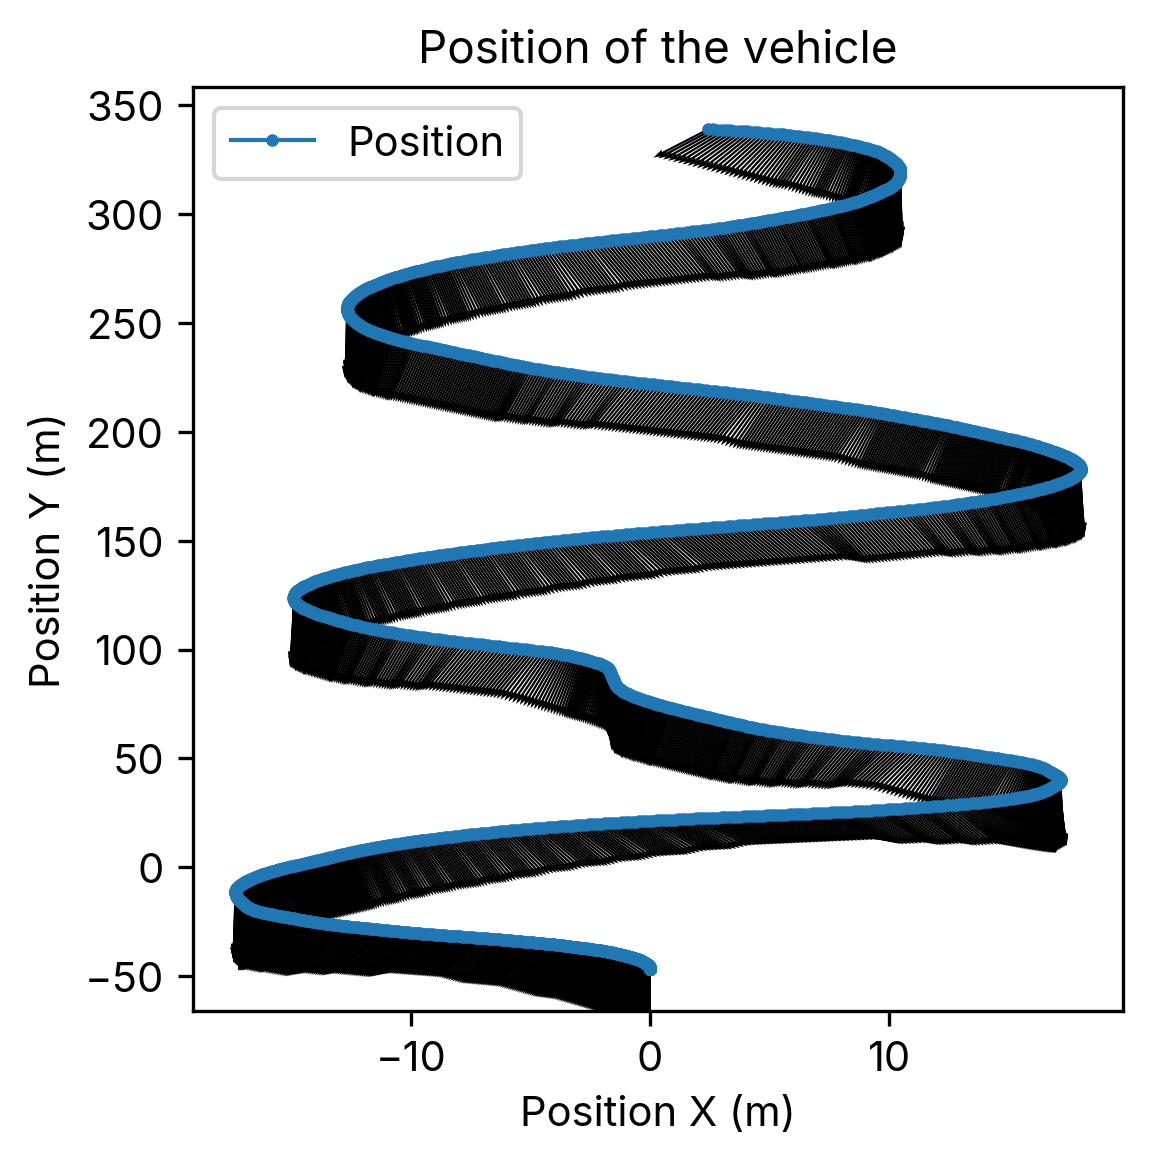

In [60]:
# Plot the positions of the vehicle in x,y along with an arrow representing the orientation of the vehicle
plt.figure(figsize=(4,4))
plt.plot(data_columns['position'][:, 0], data_columns['position'][:, 1], marker='o', linewidth=1, markersize=2, label='Position')
ANGLE_OFFSET = 0
plt.quiver(data_columns['position'][:, 0], data_columns['position'][:, 1], np.cos(data_columns['calc_rotation'][:, 2]+ANGLE_OFFSET), np.sin(data_columns['calc_rotation'][:, 2]+ANGLE_OFFSET), scale=15)
plt.xlabel('Position X (m)')
plt.ylabel('Position Y (m)')
plt.title('Position of the vehicle')
plt.legend()
plt.show()